# Investments notebook

This will be the notebook where I do my investment stuff!
Things to do:

- Time setting function: how to chose last 4-5 days for patterns? just use tail(5) and iloc!
- Implement patterns and confirmation
- Implement stock indicators
- Implement basic screener
- Implement entry rules and position sizing

Make the necessary imports to what follows

In [99]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from functions import simple_moving_average, exponential_moving_average, full_stochastic

# Import S&P500 data

spx = yf.Ticker("^GSPC")
df_spx = spx.history(period="200d").drop(["Dividends","Stock Splits"], axis = 1)

## 1. Filter for relevant stocks

### 1.1 High volume stocks

Low volume stocks carry a higher risk of investment. Thus, it is recommended to focus our attention is stocks that are traded daily with a high volume. In this section, we consider only the stocks which have been traded consistently with an average volume of 200000 in the past 30 days. Given that this process is time consuming, these stocks are saved in a list of high volume stocks for later use. We recommend to re-run this block at least once per month to guarantee that the list of high volume stocks is up to date.

In [ ]:
tickers_nasdaq = pd.read_csv("tickers_nasdaq.csv").Ticker.to_list()
tickers_nyse = pd.read_csv("tickers_nyse.csv").Ticker.to_list()

stock_tickers = tickers_nasdaq + tickers_nyse

high_volume_stocks = []

for ticker in stock_tickers:
    
    try:
        if yf.Ticker(ticker).history(period="3mo").Volume.mean() > 200000:
            high_volume_stocks.append(ticker)
            
    except:
        continue

pd.DataFrame(high_volume_stocks,columns=["Ticker"]).to_csv("high_volume_stocks.csv")

### 1.2 Relative strength analysis

Relative strength measures how well a stock has performed in comparison with the market indicator, i.e., the S&P500. Long positions for stocks with large relative strengths and short positions for stocks with small relative strengths are less risky than the other way around. Thus, it is recommended that, during an uptrend, one focuses on stocks with large relative strengths, and vice-versa for downtrends. This section filters the high volume stocks and separates them into two lists, one for strong and one for weak stocks, in comparison with the S&P500, in the past 30 days. These lists are saved in a file. It is recommended to run this block at least once per month to guarantee that the lists are updated.

In [ ]:
spx_change = (df_spx.tail(30).iloc[29].Close - df_spx.tail(30).iloc[0].Close) / df_spx.tail(30).iloc[0].Close

strong_stocks = []
weak_stocks = []

for stock in high_volume_stocks:
    
    try:
        stock_data = yf.Ticker(stock).history(period="3mo")
        stock_change = (stock_data.tail(30).iloc[29].Close - stock_data.tail(30).iloc[0].Close) / stock_data.tail(30).iloc[0].Close
    
        if stock_change > spx_change:
            strong_stocks.append(stock)
        else:
            weak_stocks.append(stock)
        
    except:
        continue
        
pd.DataFrame(strong_stocks,columns=["Ticker"]).to_csv("strong_stocks.csv")
pd.DataFrame(weak_stocks,columns=["Ticker"]).to_csv("weak_stocks.csv")

### 1.3 Importing stock lists

If you have already generated the lists of high volume stocks and stocks with strong or weak relative strength in comparison to the S&P500, you can simply run the cell below to import these lists. We recommend re-running the cells above at least once per month to keep the lists updated

In [102]:
high_volume_stocks_df = pd.read_csv("high_volume_stocks.csv").Ticker
strong_stocks_df = pd.read_csv("strong_stocks.csv").Ticker
weak_stocks_df = pd.read_csv("weak_stocks.csv").Ticker

## 2. Strategy type selection

### 2.1 Verification of market trend

Use four moving averages with different periods to verify the short-term and long-term trends of the S&P500. This analysis serves to decide wether to go for long or short strategies, when the market is bullish or bearish, respectively. If the market is found to be currently indecisive or trending sideways, it is recommended to stay out of the market. 

In [106]:
# Compute simple moving averages 50, 100, 200 and exponential moving averages 20 and 40

sma_periods = [50, 100, 200]
ema_periods = [20, 40]

for period in sma_periods:
    simple_moving_average(df_spx, period)
    
for period in ema_periods:
    exponential_moving_average(df_spx, period)

# Verifies short- and long-time trends

short_uptrend = (df_spx.tail(1).Close > df_spx.tail(1).EMA20).bool() and (df_spx.tail(1).EMA20 > df_spx.tail(1).EMA40).bool()  
short_downtrend = (df_spx.tail(1).Close < df_spx.tail(1).EMA20).bool() and (df_spx.tail(1).EMA20 < df_spx.tail(1).EMA40).bool()

long_uptrend = (df_spx.tail(1).Close > df_spx.tail(1).SMA50).bool() and (df_spx.tail(1).SMA50 > df_spx.tail(1).SMA100).bool() and (df_spx.tail(1).SMA100 > df_spx.tail(1).SMA200).bool()
long_downtrend = (df_spx.tail(1).Close < df_spx.tail(1).SMA50).bool() and (df_spx.tail(1).SMA50 < df_spx.tail(1).SMA100).bool() and (df_spx.tail(1).SMA100 < df_spx.tail(1).SMA200).bool()

market_uptrend = short_uptrend and long_uptrend
market_downtrend = short_downtrend and long_downtrend

### 2.2 Verification of price oscillation

Even if the market is found to be currently uptrending or downtrending, one might prefer to stay out of the market in case the market is currently overbought or oversold, respectively. To verify wether this is the case, we recur to a simple stochastic indicator. Long strategies are recommended if the market is uptrending and not overbought, whereas short strategies are recommended if the market is downtrending and not oversold. Otherwise, it is recommended to stay out of the market until it regresses to the mean.

In [107]:
# Applies the stochastic oscillator to the data and checks price condition

full_stochastic(df_spx,5,3,3)

market_oversold = (df_spx.tail(1)["Fast K"] < 20).bool() and (df_spx.tail(1)["Slow K"] < 20).bool()
market_overbought = (df_spx.tail(1)["Fast K"] > 80).bool() and (df_spx.tail(1)["Slow K"] > 80).bool()

# Checks trend and price status to decide the strategy type to follow

long_bias = market_uptrend and not market_overbought
short_bias = market_downtrend and not market_oversold

### 2.3 Decision for market strategies

Taking into consideration the trend of the market and the current price status, we conclude which type of strategy to follow. If the market is currently uptrending and not in an overbought state, long positions are recommended. If the market is currently downtrending and not in an oversold state, short positions are recommended. Otherwise, it is recommended to stay inective until the market retraces.

Market is currently good for long positions.


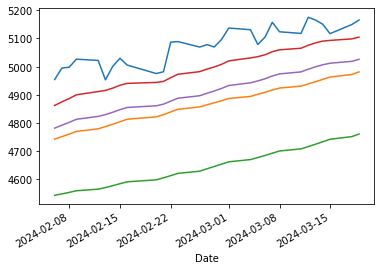

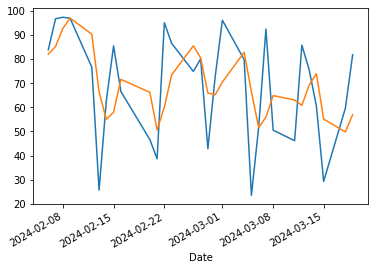

In [108]:
if market_uptrend and not market_overbought:
    stocks_to_screen = strong_stocks_df
    print("Market is currently good for long positions.")
    
elif market_downtrend and not market_oversold:
    stocks_to_screen = weak_stocks_df
    print("Market is currently good for short positions.")
    
else:
    print("Market is currently indecisive.")
    
df_spx.tail(30).Close.plot()
df_spx.tail(30).SMA50.plot()
df_spx.tail(30).SMA100.plot()
df_spx.tail(30).EMA20.plot()
df_spx.tail(30).EMA40.plot()
plt.show()

df_spx.tail(30)["Fast K"].plot()
df_spx.tail(30)["Slow K"].plot()
plt.show()

# WHATEVER IS AFTER THIS IS NOT IMPLEMENTED!

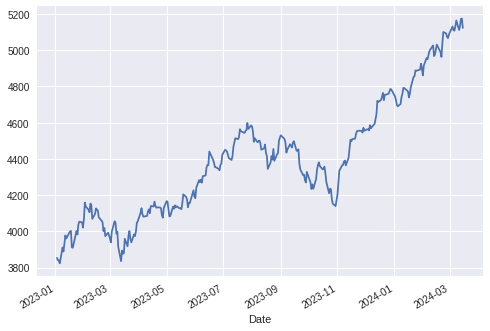

In [30]:
data.Open.plot()
plt.show()

In [17]:
msft = yf.Ticker("MSFT")

In [18]:
msft

yfinance.Ticker object <MSFT>

In [3]:
spx = yf.Ticker("^GSPC")

In [31]:
msft.history(period="1y").Volume
msft.history(start="2020-01-01", end="2021-01-01").Volume

Date
2020-01-02 00:00:00-05:00    22622100
2020-01-03 00:00:00-05:00    21116200
2020-01-06 00:00:00-05:00    20813700
2020-01-07 00:00:00-05:00    21634100
2020-01-08 00:00:00-05:00    27746500
                               ...   
2020-12-24 00:00:00-05:00    10550600
2020-12-28 00:00:00-05:00    17933500
2020-12-29 00:00:00-05:00    17403200
2020-12-30 00:00:00-05:00    20272300
2020-12-31 00:00:00-05:00    20942100
Name: Volume, Length: 253, dtype: int64

In [19]:
msft.balance_sheet

,2023-06-30,2022-06-30,2021-06-30,2020-06-30
Ordinary Shares Number,7432000000.0,7464000000.0,7519000000.0,7571000000.0
Share Issued,7432000000.0,7464000000.0,7519000000.0,7571000000.0
Net Debt,12533000000.0,35850000000.0,43922000000.0,49751000000.0
Total Debt,59965000000.0,61270000000.0,67775000000.0,70998000000.0
Tangible Book Value,128971000000.0,87720000000.0,84477000000.0,67915000000.0
...,...,...,...,...
Cash Cash Equivalents And Short Term Investments,111256000000.0,104749000000.0,130256000000.0,136527000000.0
Other Short Term Investments,76552000000.0,90818000000.0,116032000000.0,122951000000.0
Cash And Cash Equivalents,34704000000.0,13931000000.0,14224000000.0,13576000000.0
Cash Equivalents,26226000000.0,5673000000.0,6952000000.0,7666000000.0


In [16]:
stocks = tickers.tickers

for i in stocks:
    print(i)

SPY


In [ ]:
data = yf.download('^GSPC','2023-01-01','2024-03-16')

In [17]:
stock_tickers = pd.read_csv("stock_info.csv").Ticker.to_list()

high_volume = []

for ticker in stock_tickers[0:100]:

    if yf.Ticker(ticker).history(period="3mo").Volume.mean() > 200000:
        
        high_volume.append(ticker)




AAV: No price data found, symbol may be delisted (period=3mo)
ABB: No data found, symbol may be delisted
ABC: No data found, symbol may be delisted
ABR-PA: No data found, symbol may be delisted
ABR-PB: No data found, symbol may be delisted
ABV: No price data found, symbol may be delisted (period=3mo)
ABV.C: No price data found, symbol may be delisted (period=3mo)
ABW-PB: Period '3mo' is invalid, must be one of ['1d', '5d']
ABX: No price data found, symbol may be delisted (period=3mo)
ACE: No price data found, symbol may be delisted (period=3mo)
ACG: No price data found, symbol may be delisted (period=3mo)
ACH: No data found, symbol may be delisted
ACMP: No price data found, symbol may be delisted (period=3mo)
ACO: No price data found, symbol may be delisted (period=3mo)
ACW: No price data found, symbol may be delisted (period=3mo)
ADS: No data found, symbol may be delisted
AEB: No price data found, symbol may be delisted (period=3mo)
AEC: No price data found, symbol may be delisted (pe

In [32]:
good_stocks = []
i=0

for ticker in stock_tickers:
    
    if len(yf.Ticker(ticker).history(period="3mo")) > 0:
        
        good_stocks.append(ticker)
        
    if i%100 == 0:
        print("done {} times".format(i))
        
    i+=1
    



done 0 times


AAV: No price data found, symbol may be delisted (period=3mo)
ABB: No data found, symbol may be delisted
ABC: No data found, symbol may be delisted
ABR-PA: No data found, symbol may be delisted
ABR-PB: No data found, symbol may be delisted
ABV: No price data found, symbol may be delisted (period=3mo)
ABV.C: No price data found, symbol may be delisted (period=3mo)
ABW-PB: Period '3mo' is invalid, must be one of ['1d', '5d']
ABX: No price data found, symbol may be delisted (period=3mo)
ACE: No price data found, symbol may be delisted (period=3mo)
ACG: No price data found, symbol may be delisted (period=3mo)
ACH: No data found, symbol may be delisted
ACMP: No price data found, symbol may be delisted (period=3mo)
ACO: No price data found, symbol may be delisted (period=3mo)
ACW: No price data found, symbol may be delisted (period=3mo)
ADS: No data found, symbol may be delisted
AEB: No price data found, symbol may be delisted (period=3mo)
AEC: No price data found, symbol may be delisted (pe

done 100 times


AIY: No data found, symbol may be delisted
AKO.A: No data found, symbol may be delisted
AKO.B: No data found, symbol may be delisted
AKP: No data found, symbol may be delisted
AKS: No data found, symbol may be delisted
ALDW: No price data found, symbol may be delisted (period=3mo)
ALJ: No price data found, symbol may be delisted (period=3mo)
ALL-A: No data found, symbol may be delisted
ALL-B: No data found, symbol may be delisted
ALP-N: No data found, symbol may be delisted
ALP-O: No data found, symbol may be delisted
ALP-P: No data found, symbol may be delisted
ALR: No data found, symbol may be delisted
ALR-B: No data found, symbol may be delisted
ALU: No price data found, symbol may be delisted (period=3mo)
AMP-A: No data found, symbol may be delisted
AMRE: No price data found, symbol may be delisted (period=3mo)
AMT-A: No data found, symbol may be delisted
AMTG: No price data found, symbol may be delisted (period=3mo)
ANFI: No data found, symbol may be delisted
ANH: No data found, s

done 200 times


AT: No data found, symbol may be delisted
ATE: No price data found, symbol may be delisted (period=3mo)
ATHL: No price data found, symbol may be delisted (period=3mo)
ATK: No price data found, symbol may be delisted (period=3mo)
ATLS: No data found, symbol may be delisted
ATU: No data found, symbol may be delisted
ATV: No data found, symbol may be delisted
ATW: No price data found, symbol may be delisted (period=3mo)
AU-A: No data found, symbol may be delisted
AUO: No data found, symbol may be delisted
AUQ: No price data found, symbol may be delisted (period=3mo)
AUY: No data found, symbol may be delisted
AV: No price data found, symbol may be delisted (period=3mo)
AVG: No price data found, symbol may be delisted (period=3mo)
AVIV : No data found, symbol may be delisted
AVP: No data found, symbol may be delisted
AVV: No data found, symbol may be delisted
AVX: No data found, symbol may be delisted
AWC: No price data found, symbol may be delisted (period=3mo)
AXE: No data found, symbol m

done 300 times


BHI: No price data found, symbol may be delisted (period=3mo)
BHL: No price data found, symbol may be delisted (period=3mo)
BHY: No price data found, symbol may be delisted (period=3mo)
BID: No data found, symbol may be delisted
BIE: No price data found, symbol may be delisted (period=3mo)
BIF: No data found, symbol may be delisted
BIN: No price data found, symbol may be delisted (period=3mo)
BIO.B: No price data found, symbol may be delisted (period=3mo)
BIOA: No price data found, symbol may be delisted (period=3mo)
BITA: No data found, symbol may be delisted
BJZ: No price data found, symbol may be delisted (period=3mo)
BK-C: No data found, symbol may be delisted
BKI: No data found, symbol may be delisted
BKK: No data found, symbol may be delisted
BKS: No data found, symbol may be delisted
BKW: No price data found, symbol may be delisted (period=3mo)
BLC: No price data found, symbol may be delisted (period=3mo)
BLH: No price data found, symbol may be delisted (period=3mo)
BLL: No data

done 400 times


BWC: No data found, symbol may be delisted
BWP: No price data found, symbol may be delisted (period=3mo)
BXP-B: No data found, symbol may be delisted
BXS: No data found, symbol may be delisted
BXS-A: No data found, symbol may be delisted
BYI: No price data found, symbol may be delisted (period=3mo)
BZT: No data found, symbol may be delisted
BZU: No price data found, symbol may be delisted (period=3mo)
C-C: No data found, symbol may be delisted
C-E: No data found, symbol may be delisted
C-N: No data found, symbol may be delisted
C-P: No data found, symbol may be delisted
C-Q: No data found, symbol may be delisted
C-R: No data found, symbol may be delisted
C-S: No data found, symbol may be delisted
C.A: No data found, symbol may be delisted
C.B: No price data found, symbol may be delisted (period=3mo)
CAB: No price data found, symbol may be delisted (period=3mo)
CAJ: No data found, symbol may be delisted
CAM: No price data found, symbol may be delisted (period=3mo)
CAP: No data found, sy

done 500 times


CGI: No price data found, symbol may be delisted (period=3mo)
CGX: No price data found, symbol may be delisted (period=3mo)
CHA: No data found, symbol may be delisted
CHC: No price data found, symbol may be delisted (period=3mo)
CHC.W: No data found, symbol may be delisted
CHK-D: No data found, symbol may be delisted
CHL: No data found, symbol may be delisted
CHMT: No data found, symbol may be delisted
CHS: No data found, symbol may be delisted
CHS-A: No data found, symbol may be delisted
CHSP: No data found, symbol may be delisted
CHU: No data found, symbol may be delisted
CIE: No price data found, symbol may be delisted (period=3mo)
CIG.C: No data found, symbol may be delisted
CIR: No data found, symbol may be delisted
CIS: No price data found, symbol may be delisted (period=3mo)
CIT: No data found, symbol may be delisted
CJES: No price data found, symbol may be delisted (period=3mo)
CKH: No data found, symbol may be delisted
CKP: No price data found, symbol may be delisted (period=3

done 600 times


CPE-A: No data found, symbol may be delisted
CPL: No data found, symbol may be delisted
CPN: No price data found, symbol may be delisted (period=3mo)
CQB: No price data found, symbol may be delisted (period=3mo)
CRD.A: No data found, symbol may be delisted
CRD.B: No data found, symbol may be delisted
CRR: No data found, symbol may be delisted
CRY: No data found, symbol may be delisted
CS: No data found, symbol may be delisted
CSC: No price data found, symbol may be delisted (period=3mo)
CSE: No price data found, symbol may be delisted (period=3mo)
CSFS: No price data found, symbol may be delisted (period=3mo)
CSG: No price data found, symbol may be delisted (period=3mo)
CSH: No price data found, symbol may be delisted (period=3mo)
CSI: No price data found, symbol may be delisted (period=3mo)
CSP: No price data found, symbol may be delisted (period=3mo)
CSS: No data found, symbol may be delisted
CST: No price data found, symbol may be delisted (period=3mo)
CSU: No data found, symbol may

done 700 times


DCA: No price data found, symbol may be delisted (period=3mo)
DCE: No data found, symbol may be delisted
DCM: No price data found, symbol may be delisted (period=3mo)
DCT: No data found, symbol may be delisted
DCUA: No data found, symbol may be delisted
DCUB: No data found, symbol may be delisted
DD-A: No data found, symbol may be delisted
DD-B: No data found, symbol may be delisted
DDE: No data found, symbol may be delisted
DDF: No data found, symbol may be delisted
DDR: No price data found, symbol may be delisted (period=3mo)
DDR-H: No data found, symbol may be delisted
DDR-J: No data found, symbol may be delisted
DDR-K: No data found, symbol may be delisted
DEG: No price data found, symbol may be delisted (period=3mo)
DEL: No price data found, symbol may be delisted (period=3mo)
DEX: No data found, symbol may be delisted
DF: No data found, symbol may be delisted
DFS-B: No data found, symbol may be delisted
DFT: No price data found, symbol may be delisted (period=3mo)
DFT-A: No data 

done 800 times


DTK: No price data found, symbol may be delisted (period=3mo)
DTQ: No data found, symbol may be delisted
DTT: No price data found, symbol may be delisted (period=3mo)
DTZ: No data found, symbol may be delisted
DUA: No data found, symbol may be delisted
DUC: No data found, symbol may be delisted
DUKH: No price data found, symbol may be delisted (period=3mo)
DVD: No data found, symbol may be delisted
DVM: No price data found, symbol may be delisted (period=3mo)
DVR: No price data found, symbol may be delisted (period=3mo)
DW: No price data found, symbol may be delisted (period=3mo)
DWRE: No price data found, symbol may be delisted (period=3mo)
DX-A: No data found, symbol may be delisted
DX-B: No data found, symbol may be delisted
DXB: No data found, symbol may be delisted
DYN.W: No data found, symbol may be delisted
EAA: No price data found, symbol may be delisted (period=3mo)
EAB: No data found, symbol may be delisted
EAE: No data found, symbol may be delisted
EBR.B: No data found, symb

done 900 times


EOC: No price data found, symbol may be delisted (period=3mo)
EP-C: No data found, symbol may be delisted
EPB: No price data found, symbol may be delisted (period=3mo)
EPL: No price data found, symbol may be delisted (period=3mo)
EPR-C: No data found, symbol may be delisted
EPR-E: No data found, symbol may be delisted
EPR-F: No data found, symbol may be delisted
EQM: No data found, symbol may be delisted
EQU: No price data found, symbol may be delisted (period=3mo)
EQY: No price data found, symbol may be delisted (period=3mo)
ERA: No data found, symbol may be delisted
ESC: No price data found, symbol may be delisted (period=3mo)
ESD: No price data found, symbol may be delisted (period=3mo)
ESL: No data found, symbol may be delisted
ESS-H: No data found, symbol may be delisted
ESV: No data found, symbol may be delisted
ETE: No price data found, symbol may be delisted (period=3mo)
ETH: No data found, symbol may be delisted
ETM: No data found, symbol may be delisted
EVHC: No price data fo

done 1000 times


FEO: No data found, symbol may be delisted
FHN-A: No data found, symbol may be delisted
FHY: No data found, symbol may be delisted
FII: No data found, symbol may be delisted
FIO: No price data found, symbol may be delisted (period=3mo)
FLTX: No price data found, symbol may be delisted (period=3mo)
FLY: No data found, symbol may be delisted
FMD: No price data found, symbol may be delisted (period=3mo)
FNF-B: No data found, symbol may be delisted
FNP: No price data found, symbol may be delisted (period=3mo)
FOE: No data found, symbol may be delisted
FPO: No price data found, symbol may be delisted (period=3mo)
FPO-A: No data found, symbol may be delisted
FPT: No price data found, symbol may be delisted (period=3mo)
FRC: No data found, symbol may be delisted
FRC-A: No data found, symbol may be delisted
FRC-B: No data found, symbol may be delisted
FRC-C: No data found, symbol may be delisted
FRC-D: No data found, symbol may be delisted
FRF: No data found, symbol may be delisted
FRM: No pri

done 1100 times


GDI: No data found, symbol may be delisted
GDL-B: No data found, symbol may be delisted
GDP: No data found, symbol may be delisted
GDP-C: No data found, symbol may be delisted
GDP-D: No data found, symbol may be delisted
GDV-A: No data found, symbol may be delisted
GDV-D: No data found, symbol may be delisted
GE-A: No data found, symbol may be delisted
GEB: No price data found, symbol may be delisted (period=3mo)
GEF.B: No price data found, symbol may be delisted (period=3mo)
GEH: No data found, symbol may be delisted
GEK: No data found, symbol may be delisted
GEQ: No price data found, symbol may be delisted (period=3mo)
GFA: No price data found, symbol may be delisted (period=3mo)
GFIG: No price data found, symbol may be delisted (period=3mo)
GFY: No data found, symbol may be delisted
GG: No data found, symbol may be delisted
GGP: No price data found, symbol may be delisted (period=3mo)
GGP-A: No data found, symbol may be delisted
GGS: No price data found, symbol may be delisted (peri

done 1200 times


GRT-G: No data found, symbol may be delisted
GRT-H: No data found, symbol may be delisted
GRT-I: No data found, symbol may be delisted
GRX-A: No data found, symbol may be delisted
GS-A: No data found, symbol may be delisted
GS-B: No data found, symbol may be delisted
GS-C: No data found, symbol may be delisted
GS-D: No data found, symbol may be delisted
GS-I: No data found, symbol may be delisted
GS-J: No data found, symbol may be delisted
GSE: No price data found, symbol may be delisted (period=3mo)
GSF: No price data found, symbol may be delisted (period=3mo)
GSH: No data found, symbol may be delisted
GSI: No price data found, symbol may be delisted (period=3mo)
GSJ: No data found, symbol may be delisted
GTN.A: No data found, symbol may be delisted
GTS: No data found, symbol may be delisted
GUA: No price data found, symbol may be delisted (period=3mo)
GUT-A: No data found, symbol may be delisted
GWAY: No price data found, symbol may be delisted (period=3mo)
GWR: No data found, symbol

done 1300 times


HK: No data found, symbol may be delisted
HL-B: No data found, symbol may be delisted
HLS: No price data found, symbol may be delisted (period=3mo)
HMA: No data found, symbol may be delisted
HME: No price data found, symbol may be delisted (period=3mo)
HMH: No data found, symbol may be delisted
HNP: No data found, symbol may be delisted
HNR: No price data found, symbol may be delisted (period=3mo)
HNT: No price data found, symbol may be delisted (period=3mo)
HOS: No data found, symbol may be delisted
HOT: No price data found, symbol may be delisted (period=3mo)
HOVU: Period '3mo' is invalid, must be one of ['1d', '5d']
HPP-B: No data found, symbol may be delisted
HPT: No data found, symbol may be delisted
HPT-D: No data found, symbol may be delisted
HPY: No price data found, symbol may be delisted (period=3mo)
HRC: No data found, symbol may be delisted
HRG: No price data found, symbol may be delisted (period=3mo)
HRS: No data found, symbol may be delisted
HSA: Period '3mo' is invalid, 

done 1400 times


IGK: Period '3mo' is invalid, must be one of ['1d', '5d']
IHC: No data found, symbol may be delisted
IID: No data found, symbol may be delisted
IL: No price data found, symbol may be delisted (period=3mo)
IM: No price data found, symbol may be delisted (period=3mo)
IMF: No price data found, symbol may be delisted (period=3mo)
IMN: No price data found, symbol may be delisted (period=3mo)
IMPV: No price data found, symbol may be delisted (period=3mo)
IN: No price data found, symbol may be delisted (period=3mo)
INB: No data found, symbol may be delisted
IND: No price data found, symbol may be delisted (period=3mo)
INF: No data found, symbol may be delisted
INN-A: No data found, symbol may be delisted
INN-B: No data found, symbol may be delisted
INN-C: No data found, symbol may be delisted
INT: No data found, symbol may be delisted
INVN: No price data found, symbol may be delisted (period=3mo)
INXN: No data found, symbol may be delisted
INZ: No price data found, symbol may be delisted (per

done 1500 times


JLA: No data found, symbol may be delisted
JMF: No data found, symbol may be delisted
JMI: No price data found, symbol may be delisted (period=3mo)
JMP: No data found, symbol may be delisted
JMPB: No data found, symbol may be delisted
JMT: No data found, symbol may be delisted
JNS: No price data found, symbol may be delisted (period=3mo)
JNY: No price data found, symbol may be delisted (period=3mo)
JONE: No data found, symbol may be delisted
JOY: No price data found, symbol may be delisted (period=3mo)
JPG: No data found, symbol may be delisted
JPM-A: No data found, symbol may be delisted
JPM-C: No data found, symbol may be delisted
JPM-D: No data found, symbol may be delisted
JPM-I: No data found, symbol may be delisted
JPM.W: No data found, symbol may be delisted
JPS: No data found, symbol may be delisted
JPW: No price data found, symbol may be delisted (period=3mo)
JPZ: No price data found, symbol may be delisted (period=3mo)
JRN: No price data found, symbol may be delisted (period=

done 1600 times


KOG: No price data found, symbol may be delisted (period=3mo)
KORS: No price data found, symbol may be delisted (period=3mo)
KRA: No data found, symbol may be delisted
KRC-G: No data found, symbol may be delisted
KRC-H: No data found, symbol may be delisted
KRG-A: No data found, symbol may be delisted
KST: No price data found, symbol may be delisted (period=3mo)
KSU: No data found, symbol may be delisted
KSU.P: No price data found, symbol may be delisted (period=3mo)
KTP: No data found, symbol may be delisted
KWK: No price data found, symbol may be delisted (period=3mo)
KWN: No data found, symbol may be delisted
KYE: No price data found, symbol may be delisted (period=3mo)
KYN-E: No data found, symbol may be delisted
KYN-F: No data found, symbol may be delisted
KYO: No price data found, symbol may be delisted (period=3mo)
LAS: No price data found, symbol may be delisted (period=3mo)
LBF: No price data found, symbol may be delisted (period=3mo)
LCC: No price data found, symbol may be de

done 1700 times


LVLT: No price data found, symbol may be delisted (period=3mo)
LXFT: No data found, symbol may be delisted
LXK: No price data found, symbol may be delisted (period=3mo)
LXP-C: No data found, symbol may be delisted
LYG-A: No data found, symbol may be delisted
MBT: No data found, symbol may be delisted
MCA: No data found, symbol may be delisted
MCC: No data found, symbol may be delisted
MCP: No price data found, symbol may be delisted (period=3mo)
MCP-A: No data found, symbol may be delisted
MCQ: No data found, symbol may be delisted
MCV: No data found, symbol may be delisted
MDP: No data found, symbol may be delisted
MDR: No data found, symbol may be delisted
MEN: No data found, symbol may be delisted
MER-D: No data found, symbol may be delisted
MER-E: No data found, symbol may be delisted
MER-F: No data found, symbol may be delisted
MER-K: No data found, symbol may be delisted
MER-M: No data found, symbol may be delisted
MER-P: No data found, symbol may be delisted
MET-A: No data found

done 1800 times


MJN: No price data found, symbol may be delisted (period=3mo)
MKC.V: No data found, symbol may be delisted
MLG: No price data found, symbol may be delisted (period=3mo)
MLU: No price data found, symbol may be delisted (period=3mo)
MM: No price data found, symbol may be delisted (period=3mo)
MMP: No data found, symbol may be delisted
MN: No data found, symbol may be delisted
MNE: No data found, symbol may be delisted
MNI: No data found, symbol may be delisted
MNK: No data found, symbol may be delisted
MNP: No data found, symbol may be delisted
MNR-A: No data found, symbol may be delisted
MNR-B: No data found, symbol may be delisted
MOG.A: No data found, symbol may be delisted
MOG.B: No data found, symbol may be delisted
MON: No data found, symbol may be delisted
MP-D: No data found, symbol may be delisted
MPG: No price data found, symbol may be delisted (period=3mo)
MPG-A: No data found, symbol may be delisted
MPO: No data found, symbol may be delisted
MPR: No price data found, symbol m

done 1900 times


MUS: No data found, symbol may be delisted
MVC: No data found, symbol may be delisted
MVCB: No data found, symbol may be delisted
MW: No price data found, symbol may be delisted (period=3mo)
MWE: No price data found, symbol may be delisted (period=3mo)
MWO: No price data found, symbol may be delisted (period=3mo)
MWR: No price data found, symbol may be delisted (period=3mo)
MWV: No price data found, symbol may be delisted (period=3mo)
MWW: No price data found, symbol may be delisted (period=3mo)
MXT: No price data found, symbol may be delisted (period=3mo)
MY: No price data found, symbol may be delisted (period=3mo)
MYC: No price data found, symbol may be delisted (period=3mo)
MYF: No data found, symbol may be delisted
MYJ: No data found, symbol may be delisted
MYM: No price data found, symbol may be delisted (period=3mo)
MZF: No price data found, symbol may be delisted (period=3mo)
N: No price data found, symbol may be delisted (period=3mo)
NAD-C: No data found, symbol may be delisted

done 2000 times


NKA: No price data found, symbol may be delisted (period=3mo)
NKG-C: No data found, symbol may be delisted
NKG-D: No data found, symbol may be delisted
NLS: No data found, symbol may be delisted
NLSN: No data found, symbol may be delisted
NLY-A: No data found, symbol may be delisted
NLY-C: No data found, symbol may be delisted
NLY-D: No data found, symbol may be delisted
NM: No data found, symbol may be delisted
NMA: No price data found, symbol may be delisted (period=3mo)
NMK-B: No data found, symbol may be delisted
NMK-C: No data found, symbol may be delisted
NMO: No price data found, symbol may be delisted (period=3mo)
NMT-C: No data found, symbol may be delisted
NMT-D: No data found, symbol may be delisted
NMY: No data found, symbol may be delisted
NMY-C: No data found, symbol may be delisted
NMY-D: No data found, symbol may be delisted
NMY-E: No data found, symbol may be delisted
NMY-F: No data found, symbol may be delisted
NMY-G: No data found, symbol may be delisted
NMY-H: No da

done 2100 times


NTC: No data found, symbol may be delisted
NTC-C: No data found, symbol may be delisted
NTC-D: No data found, symbol may be delisted
NTC-E: No data found, symbol may be delisted
NTC-F: No data found, symbol may be delisted
NTC-G: No data found, symbol may be delisted
NTE: No price data found, symbol may be delisted (period=3mo)
NTI: No price data found, symbol may be delisted (period=3mo)
NTL: No price data found, symbol may be delisted (period=3mo)
NTT: No price data found, symbol may be delisted (period=3mo)
NTX: No data found, symbol may be delisted
NTX-C: No data found, symbol may be delisted
NUC: No price data found, symbol may be delisted (period=3mo)
NUJ-C: No data found, symbol may be delisted
NUM: No data found, symbol may be delisted
NUO: No data found, symbol may be delisted
NUO-C: No data found, symbol may be delisted
NVC: No price data found, symbol may be delisted (period=3mo)
NVE: No price data found, symbol may be delisted (period=3mo)
NVG-C: No data found, symbol may b

done 2200 times


ORB: No price data found, symbol may be delisted (period=3mo)
OWW: No price data found, symbol may be delisted (period=3mo)
OXF: No price data found, symbol may be delisted (period=3mo)
OZM: No data found, symbol may be delisted
P: No price data found, symbol may be delisted (period=3mo)
PACD: No data found, symbol may be delisted
PBI-A: No data found, symbol may be delisted
PBI-B: No data found, symbol may be delisted
PBNY: No price data found, symbol may be delisted (period=3mo)
PBR.A: No data found, symbol may be delisted
PBY: No price data found, symbol may be delisted (period=3mo)
PCI: No data found, symbol may be delisted
PCL: No price data found, symbol may be delisted (period=3mo)
PCP: No price data found, symbol may be delisted (period=3mo)
PDH: No price data found, symbol may be delisted (period=3mo)
PEB-A: No data found, symbol may be delisted
PEB-B: No data found, symbol may be delisted
PEB-C: No data found, symbol may be delisted
PEI: No data found, symbol may be delisted


done 2300 times


PJS: No price data found, symbol may be delisted (period=3mo)
PKD: No data found, symbol may be delisted
PKH: No price data found, symbol may be delisted (period=3mo)
PKI: No data found, symbol may be delisted
PKO: No data found, symbol may be delisted
PKY: No price data found, symbol may be delisted (period=3mo)
PL-B: No data found, symbol may be delisted
PL-C: No data found, symbol may be delisted
PL-E: No data found, symbol may be delisted
PLP: No price data found, symbol may be delisted (period=3mo)
PLT: No data found, symbol may be delisted
PMC: No price data found, symbol may be delisted (period=3mo)
PNC-P: No data found, symbol may be delisted
PNC-Q: No data found, symbol may be delisted
PNC.W: No data found, symbol may be delisted
PNG: No price data found, symbol may be delisted (period=3mo)
PNK: No price data found, symbol may be delisted (period=3mo)
PNTA: No price data found, symbol may be delisted (period=3mo)
PNX: No price data found, symbol may be delisted (period=3mo)
PN

done 2400 times


PVA: No price data found, symbol may be delisted (period=3mo)
PVD: No price data found, symbol may be delisted (period=3mo)
PVG: No data found, symbol may be delisted
PVR: No price data found, symbol may be delisted (period=3mo)
PVTD: No price data found, symbol may be delisted (period=3mo)
PWE: No price data found, symbol may be delisted (period=3mo)
PYB: No price data found, symbol may be delisted (period=3mo)
PYC: No price data found, symbol may be delisted (period=3mo)
PYG: No price data found, symbol may be delisted (period=3mo)
PYK: No price data found, symbol may be delisted (period=3mo)
PYS: No price data found, symbol may be delisted (period=3mo)
PYV: No price data found, symbol may be delisted (period=3mo)
PYY: Period '3mo' is invalid, must be one of ['1d', '5d']
PZB: No price data found, symbol may be delisted (period=3mo)
PZE: No price data found, symbol may be delisted (period=3mo)
PZN: No data found, symbol may be delisted
Q: No price data found, symbol may be delisted (p

done 2500 times


RLD: No price data found, symbol may be delisted (period=3mo)
RLGY: No data found, symbol may be delisted
RLH: No data found, symbol may be delisted
RLH-A: No data found, symbol may be delisted
RNDY: No price data found, symbol may be delisted (period=3mo)
RNE: No price data found, symbol may be delisted (period=3mo)
RNF: No price data found, symbol may be delisted (period=3mo)
RNO: No price data found, symbol may be delisted (period=3mo)
RNR-C: No data found, symbol may be delisted
RNR-E: No data found, symbol may be delisted
ROC: No data found, symbol may be delisted
ROYT: No data found, symbol may be delisted
RPAI: No data found, symbol may be delisted
RPT: No data found, symbol may be delisted
RPT-D: No data found, symbol may be delisted
RRMS: No price data found, symbol may be delisted (period=3mo)
RSE: No price data found, symbol may be delisted (period=3mo)
RSH: No price data found, symbol may be delisted (period=3mo)
RSO: No price data found, symbol may be delisted (period=3mo)

done 2600 times


SFB: Period '3mo' is invalid, must be one of ['1d', '5d']
SFD: No price data found, symbol may be delisted (period=3mo)
SFG: No price data found, symbol may be delisted (period=3mo)
SFI: No price data found, symbol may be delisted (period=3mo)
SFI-D: No data found, symbol may be delisted
SFI-E: No data found, symbol may be delisted
SFI-F: No data found, symbol may be delisted
SFI-G: No data found, symbol may be delisted
SFI-I: No data found, symbol may be delisted
SFN: No price data found, symbol may be delisted (period=3mo)
SFUN: No data found, symbol may be delisted
SGF: No price data found, symbol may be delisted (period=3mo)
SGK: No price data found, symbol may be delisted (period=3mo)
SGL: No price data found, symbol may be delisted (period=3mo)
SGY: No price data found, symbol may be delisted (period=3mo)
SGZA: No data found, symbol may be delisted
SHI: No data found, symbol may be delisted
SHO-D: No data found, symbol may be delisted
SI: No data found, symbol may be delisted
SJI

done 2700 times


SRT: No data found, symbol may be delisted
SSI: No data found, symbol may be delisted
SSNI: No price data found, symbol may be delisted (period=3mo)
SSS: No price data found, symbol may be delisted (period=3mo)
SSW: No data found, symbol may be delisted
SSW-C: No data found, symbol may be delisted
SSW-D: No data found, symbol may be delisted
STA-A: No data found, symbol may be delisted
STI-A: No data found, symbol may be delisted
STI-E: No data found, symbol may be delisted
STI.A: No data found, symbol may be delisted
STI.B: No price data found, symbol may be delisted (period=3mo)
STJ: No price data found, symbol may be delisted (period=3mo)
STL: No data found, symbol may be delisted
STL-A: No data found, symbol may be delisted
STO: No price data found, symbol may be delisted (period=3mo)
STON: No data found, symbol may be delisted
STP: No price data found, symbol may be delisted (period=3mo)
STRI: No data found, symbol may be delisted
STT-C: No data found, symbol may be delisted
STV: 

done 2800 times


TCP: No data found, symbol may be delisted
TDA: No data found, symbol may be delisted
TDE: No data found, symbol may be delisted
TDJ: No data found, symbol may be delisted
TE: No price data found, symbol may be delisted (period=3mo)
TEG: No price data found, symbol may be delisted (period=3mo)
TEN: No data found, symbol may be delisted
TEP: No price data found, symbol may be delisted (period=3mo)
TEU: No price data found, symbol may be delisted (period=3mo)
TEU-C: No data found, symbol may be delisted
TFG: No price data found, symbol may be delisted (period=3mo)
TGP: No data found, symbol may be delisted
TGX: No price data found, symbol may be delisted (period=3mo)
THGA: No data found, symbol may be delisted
THI: No price data found, symbol may be delisted (period=3mo)
TI: No data found, symbol may be delisted
TI.A: No data found, symbol may be delisted
TIF: No data found, symbol may be delisted
TKF: No price data found, symbol may be delisted (period=3mo)
TLI: No data found, symbol ma

done 2900 times


TSO: No price data found, symbol may be delisted (period=3mo)
TSS: No data found, symbol may be delisted
TSU: No data found, symbol may be delisted
TTF: No price data found, symbol may be delisted (period=3mo)
TTM: No data found, symbol may be delisted
TUC: No price data found, symbol may be delisted (period=3mo)
TUMI: No price data found, symbol may be delisted (period=3mo)
TVL: No price data found, symbol may be delisted (period=3mo)
TWC: No price data found, symbol may be delisted (period=3mo)
TWX: No price data found, symbol may be delisted (period=3mo)
TXI: No price data found, symbol may be delisted (period=3mo)
TXTR: No price data found, symbol may be delisted (period=3mo)
TY.P: No price data found, symbol may be delisted (period=3mo)
TYC: No price data found, symbol may be delisted (period=3mo)
TYG-B: No data found, symbol may be delisted
TYN: No data found, symbol may be delisted
TYY: No data found, symbol may be delisted
TYY-C: No data found, symbol may be delisted
TZF: No pr

done 3000 times


VAR: No data found, symbol may be delisted
VCI: No price data found, symbol may be delisted (period=3mo)
VCO: No price data found, symbol may be delisted (period=3mo)
VCRA: No data found, symbol may be delisted
WAC: No price data found, symbol may be delisted (period=3mo)
WAG: No price data found, symbol may be delisted (period=3mo)
WAGE: No data found, symbol may be delisted
WAIR: No data found, symbol may be delisted
WBC: No data found, symbol may be delisted
WBK: No data found, symbol may be delisted
XAA: No price data found, symbol may be delisted (period=3mo)
XCO: No price data found, symbol may be delisted (period=3mo)
XEC: No data found, symbol may be delisted
XFP: No price data found, symbol may be delisted (period=3mo)
XFR: No price data found, symbol may be delisted (period=3mo)
XKE: No price data found, symbol may be delisted (period=3mo)
XKO: No price data found, symbol may be delisted (period=3mo)
XL: No data found, symbol may be delisted
XLS: No price data found, symbol m

done 3100 times


ADAT: No price data found, symbol may be delisted (period=3mo)
ADEP: No price data found, symbol may be delisted (period=3mo)
ADHD: No price data found, symbol may be delisted (period=3mo)
ADNC: No price data found, symbol may be delisted (period=3mo)
ADRA: No data found, symbol may be delisted
ADRD: No price data found, symbol may be delisted (period=3mo)
ADRE: No price data found, symbol may be delisted (period=3mo)
ADRU: No price data found, symbol may be delisted (period=3mo)
ADVS: No price data found, symbol may be delisted (period=3mo)
AEGN: No data found, symbol may be delisted
AEGR: No price data found, symbol may be delisted (period=3mo)
AEPI: No price data found, symbol may be delisted (period=3mo)
AERL: No price data found, symbol may be delisted (period=3mo)
AETI: No data found, symbol may be delisted
AFAM: No price data found, symbol may be delisted (period=3mo)
AFCB: No price data found, symbol may be delisted (period=3mo)
AFCE: No price data found, symbol may be delisted

done 3200 times


ANCX: No price data found, symbol may be delisted (period=3mo)
ANDA: No data found, symbol may be delisted
ANDAU: No data found, symbol may be delisted
ANDAW: No data found, symbol may be delisted
ANEN: No price data found, symbol may be delisted (period=3mo)
ANLY: No price data found, symbol may be delisted (period=3mo)
ANTP: No price data found, symbol may be delisted (period=3mo)
APAGF: No price data found, symbol may be delisted (period=3mo)
APFC: No price data found, symbol may be delisted (period=3mo)
APOL: No price data found, symbol may be delisted (period=3mo)
APPY: No price data found, symbol may be delisted (period=3mo)
APRI: No price data found, symbol may be delisted (period=3mo)
APSA: No price data found, symbol may be delisted (period=3mo)
AQUUU: No data found, symbol may be delisted
AQUUW: No data found, symbol may be delisted
ARCI: No data found, symbol may be delisted
ARCP: No price data found, symbol may be delisted (period=3mo)
ARCW: No data found, symbol may be del

done 3300 times


AVEO: No data found, symbol may be delisted
AVID: No data found, symbol may be delisted
AVNR: No price data found, symbol may be delisted (period=3mo)
AXAS: No data found, symbol may be delisted
AXFN: Period '3mo' is invalid, must be one of ['1d', '5d']
AXJS: No price data found, symbol may be delisted (period=3mo)
BABY: No data found, symbol may be delisted
BAGL: No price data found, symbol may be delisted (period=3mo)
BAGR: No price data found, symbol may be delisted (period=3mo)
BAMM: No price data found, symbol may be delisted (period=3mo)
BANCL: No data found, symbol may be delisted
BANCP: Period '3mo' is invalid, must be one of ['1d', '5d']
BASI: No data found, symbol may be delisted
BAXS: No price data found, symbol may be delisted (period=3mo)
BBBY: No data found, symbol may be delisted
BBCN: No price data found, symbol may be delisted (period=3mo)
BBEP: No price data found, symbol may be delisted (period=3mo)
BBNK: No price data found, symbol may be delisted (period=3mo)
BBOX:

done 3400 times


BONA: No price data found, symbol may be delisted (period=3mo)
BONT: No price data found, symbol may be delisted (period=3mo)
BOTA: No price data found, symbol may be delisted (period=3mo)
BPFH: No data found, symbol may be delisted
BPFHP: No data found, symbol may be delisted
BPFHW: No data found, symbol may be delisted
BPHX: No price data found, symbol may be delisted (period=3mo)
BPOPN: No data found, symbol may be delisted
BRCD: No price data found, symbol may be delisted (period=3mo)
BRCM: No price data found, symbol may be delisted (period=3mo)
BREW: No data found, symbol may be delisted
BRKS: No data found, symbol may be delisted
BRLI: No data found, symbol may be delisted
BSDM: No price data found, symbol may be delisted (period=3mo)
BSFT: No price data found, symbol may be delisted (period=3mo)
BSQR: No data found, symbol may be delisted
BSTC: No data found, symbol may be delisted
BTUI: No price data found, symbol may be delisted (period=3mo)
BVA: No price data found, symbol m

done 3500 times


CECE: No data found, symbol may be delisted
CEDU: No price data found, symbol may be delisted (period=3mo)
CELG: No data found, symbol may be delisted
CELGZ: No data found, symbol may be delisted
CEMI: No data found, symbol may be delisted
CEMP: No price data found, symbol may be delisted (period=3mo)
CERN: No data found, symbol may be delisted
CETV: No data found, symbol may be delisted
CFNL: No price data found, symbol may be delisted (period=3mo)
CGIX: No data found, symbol may be delisted
CHDX: No price data found, symbol may be delisted (period=3mo)
CHEV: No price data found, symbol may be delisted (period=3mo)
CHFC: No data found, symbol may be delisted
CHFN: No price data found, symbol may be delisted (period=3mo)
CHKE: Period '3mo' is invalid, must be one of ['1d', '5d']
CHLN: No price data found, symbol may be delisted (period=3mo)
CHOP: No price data found, symbol may be delisted (period=3mo)
CHRM: No price data found, symbol may be delisted (period=3mo)
CHTP: No price data f

done 3600 times


CNQR: No price data found, symbol may be delisted (period=3mo)
CNSI: No price data found, symbol may be delisted (period=3mo)
CNTF: No data found, symbol may be delisted
CNYD: No price data found, symbol may be delisted (period=3mo)
COA: No price data found, symbol may be delisted (period=3mo)
COB: No price data found, symbol may be delisted (period=3mo)
COBK: No price data found, symbol may be delisted (period=3mo)
COBR: No price data found, symbol may be delisted (period=3mo)
COBZ: No price data found, symbol may be delisted (period=3mo)
COGO: No price data found, symbol may be delisted (period=3mo)
CONE: No data found, symbol may be delisted
CORE: No data found, symbol may be delisted
COSI: No price data found, symbol may be delisted (period=3mo)
COWN: No data found, symbol may be delisted
CPAH: No data found, symbol may be delisted
CPGI: No price data found, symbol may be delisted (period=3mo)
CPHD: No price data found, symbol may be delisted (period=3mo)
CPLA: No price data found,

done 3700 times


CUI: No data found, symbol may be delisted
CUNB: No price data found, symbol may be delisted (period=3mo)
CVTI: No data found, symbol may be delisted
CWEI: No price data found, symbol may be delisted (period=3mo)
CWTR: No price data found, symbol may be delisted (period=3mo)
CXDC: No data found, symbol may be delisted
CXPO: No price data found, symbol may be delisted (period=3mo)
CY: No data found, symbol may be delisted
CYBE: No data found, symbol may be delisted
CYBX: No price data found, symbol may be delisted (period=3mo)
CYNO: No price data found, symbol may be delisted (period=3mo)
CYOU: No data found, symbol may be delisted
CYTR: No data found, symbol may be delisted
CYTX: No data found, symbol may be delisted
CYTXW: No data found, symbol may be delisted
CZFC: No data found, symbol may be delisted
DAEG: No price data found, symbol may be delisted (period=3mo)
DARA: No price data found, symbol may be delisted (period=3mo)
DATE: No price data found, symbol may be delisted (period=

done 3800 times


DVCR: No data found, symbol may be delisted
DWA: No price data found, symbol may be delisted (period=3mo)
DWCH: No price data found, symbol may be delisted (period=3mo)
DXM: No price data found, symbol may be delisted (period=3mo)
DXPS: No data found, symbol may be delisted
DYAX: No price data found, symbol may be delisted (period=3mo)
EAGLU: No data found, symbol may be delisted
EBIX: No data found, symbol may be delisted
EBSB: No data found, symbol may be delisted
ECHO: No data found, symbol may be delisted
ECOL: No data found, symbol may be delisted
ECTE: No data found, symbol may be delisted
ECTY: No price data found, symbol may be delisted (period=3mo)
ECYT: No price data found, symbol may be delisted (period=3mo)
EDGW: No price data found, symbol may be delisted (period=3mo)
EDMC: No price data found, symbol may be delisted (period=3mo)
EDS: No price data found, symbol may be delisted (period=3mo)
EEI: No data found, symbol may be delisted
EEME: No price data found, symbol may be

done 3900 times


ESIO: No price data found, symbol may be delisted (period=3mo)
ESRX: No price data found, symbol may be delisted (period=3mo)
ESSX: No price data found, symbol may be delisted (period=3mo)
ESXB: No data found, symbol may be delisted
ESYS: No price data found, symbol may be delisted (period=3mo)
ETFC: No data found, symbol may be delisted
ETRM: No price data found, symbol may be delisted (period=3mo)
EVAC: No price data found, symbol may be delisted (period=3mo)
EVAL: No price data found, symbol may be delisted (period=3mo)
EVBS: No price data found, symbol may be delisted (period=3mo)
EVEP: No price data found, symbol may be delisted (period=3mo)
EVRY: No price data found, symbol may be delisted (period=3mo)
EXA: No price data found, symbol may be delisted (period=3mo)
EXAC: No price data found, symbol may be delisted (period=3mo)
EXFO: No data found, symbol may be delisted
EXLP: No price data found, symbol may be delisted (period=3mo)
EXXI: No price data found, symbol may be delisted 

done 4000 times


FMBI: No data found, symbol may be delisted
FMER: No price data found, symbol may be delisted (period=3mo)
FMFC: No price data found, symbol may be delisted (period=3mo)
FNFG: No price data found, symbol may be delisted (period=3mo)
FNGN: No data found, symbol may be delisted
FNHC: No data found, symbol may be delisted
FNSR: No data found, symbol may be delisted
FONE: No price data found, symbol may be delisted (period=3mo)
FRAN: No data found, symbol may be delisted
FRED: No data found, symbol may be delisted
FRGI: No data found, symbol may be delisted
FRNK: No price data found, symbol may be delisted (period=3mo)
FRP: No price data found, symbol may be delisted (period=3mo)
FSBK: No price data found, symbol may be delisted (period=3mo)
FSC: No price data found, symbol may be delisted (period=3mo)
FSCFL: No data found, symbol may be delisted
FSCI: No price data found, symbol may be delisted (period=3mo)
FSFR: No price data found, symbol may be delisted (period=3mo)
FSGI: No price data

done 4100 times


GLADP: No data found, symbol may be delisted
GLCB: Period '3mo' is invalid, must be one of ['1d', '5d']
GLCH: No price data found, symbol may be delisted (period=3mo)
GLDC: No price data found, symbol may be delisted (period=3mo)
GLPW: No price data found, symbol may be delisted (period=3mo)
GLUU: No data found, symbol may be delisted
GMAN: No price data found, symbol may be delisted (period=3mo)
GMCR: No price data found, symbol may be delisted (period=3mo)
GMETP: No data found, symbol may be delisted
GMLP: No data found, symbol may be delisted
GNCMA: No price data found, symbol may be delisted (period=3mo)
GNMK: No data found, symbol may be delisted
GNVC: No price data found, symbol may be delisted (period=3mo)
GOODP: No data found, symbol may be delisted
GPIC: No data found, symbol may be delisted
GSJK: No price data found, symbol may be delisted (period=3mo)
GSVC: No data found, symbol may be delisted
GTAT: No data found, symbol may be delisted
GTIV: No price data found, symbol may

done 4200 times


HIIQ: No data found, symbol may be delisted
HILL: No price data found, symbol may be delisted (period=3mo)
HITK: No price data found, symbol may be delisted (period=3mo)
HITT: No price data found, symbol may be delisted (period=3mo)
HKTV: No price data found, symbol may be delisted (period=3mo)
HLSS: No price data found, symbol may be delisted (period=3mo)
HMIN: No price data found, symbol may be delisted (period=3mo)
HMPR: No price data found, symbol may be delisted (period=3mo)
HMSY: No data found, symbol may be delisted
HMTV: No data found, symbol may be delisted
HNH: No price data found, symbol may be delisted (period=3mo)
HNSN: No price data found, symbol may be delisted (period=3mo)
HOLL: No price data found, symbol may be delisted (period=3mo)
HOME: No data found, symbol may be delisted
HOTR: No price data found, symbol may be delisted (period=3mo)
HOTRW: No data found, symbol may be delisted
HPAC: No price data found, symbol may be delisted (period=3mo)
HPCCP: No price data fou

done 4300 times


IIJI: No data found, symbol may be delisted
IILG: No price data found, symbol may be delisted (period=3mo)
IIN: No data found, symbol may be delisted
IIVI: No data found, symbol may be delisted
IKAN: No price data found, symbol may be delisted (period=3mo)
IKNX: No data found, symbol may be delisted
IMI: No data found, symbol may be delisted
IMMU: No data found, symbol may be delisted
IMMY: No price data found, symbol may be delisted (period=3mo)
IMRS: No price data found, symbol may be delisted (period=3mo)
INAP: No data found, symbol may be delisted
INFI: No data found, symbol may be delisted
ININ: No price data found, symbol may be delisted (period=3mo)
INOC: No price data found, symbol may be delisted (period=3mo)
INPH: No price data found, symbol may be delisted (period=3mo)
INSY: No data found, symbol may be delisted
INTLL: No data found, symbol may be delisted
INTX: No price data found, symbol may be delisted (period=3mo)
INWK: No data found, symbol may be delisted
INXB: No data

done 4400 times


JMBA: No price data found, symbol may be delisted (period=3mo)
JOBS: No data found, symbol may be delisted
JOEZ: No price data found, symbol may be delisted (period=3mo)
JOSB: No price data found, symbol may be delisted (period=3mo)
JRCC: No price data found, symbol may be delisted (period=3mo)
JRJC: No data found, symbol may be delisted
JST: No price data found, symbol may be delisted (period=3mo)
JTPY: No price data found, symbol may be delisted (period=3mo)
JXSB: No price data found, symbol may be delisted (period=3mo)
KBALB: No price data found, symbol may be delisted (period=3mo)
KBIO: No price data found, symbol may be delisted (period=3mo)
KCAP: No data found, symbol may be delisted
KERX: No price data found, symbol may be delisted (period=3mo)
KEYN: No price data found, symbol may be delisted (period=3mo)
KEYW: No price data found, symbol may be delisted (period=3mo)
KIOR: No price data found, symbol may be delisted (period=3mo)
KIPO: No price data found, symbol may be delisted

done 4500 times


LMNX: No data found, symbol may be delisted
LMOS: No price data found, symbol may be delisted (period=3mo)
LNBB: No price data found, symbol may be delisted (period=3mo)
LNCE: No price data found, symbol may be delisted (period=3mo)
LNCO: No price data found, symbol may be delisted (period=3mo)
LNDC: No data found, symbol may be delisted
LOGM: No data found, symbol may be delisted
LOJN: No price data found, symbol may be delisted (period=3mo)
LONG: No price data found, symbol may be delisted (period=3mo)
LOOK: No price data found, symbol may be delisted (period=3mo)
LORL: No data found, symbol may be delisted
LPDX: No price data found, symbol may be delisted (period=3mo)
LPHI: No price data found, symbol may be delisted (period=3mo)
LPNT: No price data found, symbol may be delisted (period=3mo)
LPSB: No price data found, symbol may be delisted (period=3mo)
LPTN: No price data found, symbol may be delisted (period=3mo)
LRAD: No data found, symbol may be delisted
LSBI: No price data foun

done 4600 times


MERU: No price data found, symbol may be delisted (period=3mo)
METR: No price data found, symbol may be delisted (period=3mo)
MFI: No price data found, symbol may be delisted (period=3mo)
MFLR: No price data found, symbol may be delisted (period=3mo)
MFNC: No data found, symbol may be delisted
MFRI: No price data found, symbol may be delisted (period=3mo)
MFRM: No price data found, symbol may be delisted (period=3mo)
MFSF: No data found, symbol may be delisted
MGCD: No price data found, symbol may be delisted (period=3mo)
MGI: No data found, symbol may be delisted
MGLN: No data found, symbol may be delisted
MHGC: No price data found, symbol may be delisted (period=3mo)
MICT: No data found, symbol may be delisted
MICTW: No data found, symbol may be delisted
MINI: No data found, symbol may be delisted
MITL: No price data found, symbol may be delisted (period=3mo)
MKTG: No price data found, symbol may be delisted (period=3mo)
MKTO: No price data found, symbol may be delisted (period=3mo)


done 4700 times


NANO: No data found, symbol may be delisted
NATI: No data found, symbol may be delisted
NAVG: No data found, symbol may be delisted
NAVR: No price data found, symbol may be delisted (period=3mo)
NBBC: No price data found, symbol may be delisted (period=3mo)
NBCB: No price data found, symbol may be delisted (period=3mo)
NBS: No price data found, symbol may be delisted (period=3mo)
NBTF: No price data found, symbol may be delisted (period=3mo)
NCBC: No price data found, symbol may be delisted (period=3mo)
NCIT: No price data found, symbol may be delisted (period=3mo)
NETC: No data found, symbol may be delisted
NETE: No data found, symbol may be delisted
NEWL: No price data found, symbol may be delisted (period=3mo)
NEWS: No price data found, symbol may be delisted (period=3mo)
NFEC: No price data found, symbol may be delisted (period=3mo)
NFSB: No price data found, symbol may be delisted (period=3mo)
NGPC: No price data found, symbol may be delisted (period=3mo)
NHTB: No price data found

done 4800 times


NXTM: No data found, symbol may be delisted
NYMTP: No data found, symbol may be delisted
NYMX: No data found, symbol may be delisted
NYNY: No data found, symbol may be delisted
OABC: No price data found, symbol may be delisted (period=3mo)
OBAF: No price data found, symbol may be delisted (period=3mo)
OBAS: No data found, symbol may be delisted
OBCI: No data found, symbol may be delisted
OCLR: No price data found, symbol may be delisted (period=3mo)
OCLS: No price data found, symbol may be delisted (period=3mo)
OCRX: No price data found, symbol may be delisted (period=3mo)
OCZ: No price data found, symbol may be delisted (period=3mo)
OGXI: No price data found, symbol may be delisted (period=3mo)
OHRP: No data found, symbol may be delisted
OIIM: No data found, symbol may be delisted
OINK: No data found, symbol may be delisted
OKSB: No price data found, symbol may be delisted (period=3mo)
OKSBP: No price data found, symbol may be delisted (period=3mo)
OLBK: No data found, symbol may be d

done 4900 times


PBIB: No price data found, symbol may be delisted (period=3mo)
PBIP: No data found, symbol may be delisted
PBMD: No price data found, symbol may be delisted (period=3mo)
PBSK: No price data found, symbol may be delisted (period=3mo)
PCBK: No price data found, symbol may be delisted (period=3mo)
PCCC: No price data found, symbol may be delisted (period=3mo)
PCLN: No price data found, symbol may be delisted (period=3mo)
PCMI: No data found, symbol may be delisted
PCO: No price data found, symbol may be delisted (period=3mo)
PCOM: No data found, symbol may be delisted
PCTI: No data found, symbol may be delisted
PCYC: No price data found, symbol may be delisted (period=3mo)
PDCE: Period '3mo' is invalid, must be one of ['1d', '5d']
PDII: No price data found, symbol may be delisted (period=3mo)
PDLI: No data found, symbol may be delisted
PEIX: No data found, symbol may be delisted
PENX: No price data found, symbol may be delisted (period=3mo)
PEOP: No price data found, symbol may be deliste

done 5000 times


PRGX: No data found, symbol may be delisted
PRLS: No price data found, symbol may be delisted (period=3mo)
PRSC: No data found, symbol may be delisted
PRSS: No price data found, symbol may be delisted (period=3mo)
PRXI: No price data found, symbol may be delisted (period=3mo)
PRXL: No price data found, symbol may be delisted (period=3mo)
PSAU: No price data found, symbol may be delisted (period=3mo)
PSBH: No price data found, symbol may be delisted (period=3mo)
PSDV: No price data found, symbol may be delisted (period=3mo)
PSEM: No price data found, symbol may be delisted (period=3mo)
PSMI: No price data found, symbol may be delisted (period=3mo)
PSTB: No price data found, symbol may be delisted (period=3mo)
PSTI: No data found, symbol may be delisted
PSTR: No price data found, symbol may be delisted (period=3mo)
PSUN: No price data found, symbol may be delisted (period=3mo)
PTEK: No price data found, symbol may be delisted (period=3mo)
PTIE: No data found, symbol may be delisted
PTLA:

done 5100 times


RDEN: No price data found, symbol may be delisted (period=3mo)
RECN: No data found, symbol may be delisted
RECV: No price data found, symbol may be delisted (period=3mo)
REDF: No price data found, symbol may be delisted (period=3mo)
REGI: No price data found, symbol may be delisted (period=3mo)
REIS: No price data found, symbol may be delisted (period=3mo)
REMY: No price data found, symbol may be delisted (period=3mo)
REXI: No price data found, symbol may be delisted (period=3mo)
REXX: No price data found, symbol may be delisted (period=3mo)
RFMD: No price data found, symbol may be delisted (period=3mo)
RGDO: No data found, symbol may be delisted
RGDX: No price data found, symbol may be delisted (period=3mo)
RIMG: No price data found, symbol may be delisted (period=3mo)
RIVR: No price data found, symbol may be delisted (period=3mo)
RJET: No price data found, symbol may be delisted (period=3mo)
RLJE: No price data found, symbol may be delisted (period=3mo)
RLOC: No price data found, sym

done 5200 times


SBNYW: No data found, symbol may be delisted
SBRAP: No data found, symbol may be delisted
SBSA: No price data found, symbol may be delisted (period=3mo)
SCBT: No price data found, symbol may be delisted (period=3mo)
SCHN: No data found, symbol may be delisted
SCLN: No price data found, symbol may be delisted (period=3mo)
SCMP: No price data found, symbol may be delisted (period=3mo)
SCOK: No price data found, symbol may be delisted (period=3mo)
SCON: No data found, symbol may be delisted
SCSS: No price data found, symbol may be delisted (period=3mo)
SCTY: No data found, symbol may be delisted
SFLY: No data found, symbol may be delisted
SGEN: No data found, symbol may be delisted
SGI: No price data found, symbol may be delisted (period=3mo)
SGMS: No data found, symbol may be delisted
SGNT: No price data found, symbol may be delisted (period=3mo)
SGOC: No data found, symbol may be delisted
SGYP: No data found, symbol may be delisted
SGYPW: No data found, symbol may be delisted
SHFL: No p

done 5300 times


SNDK: No price data found, symbol may be delisted (period=3mo)
SNHY: No data found, symbol may be delisted
SNMX: No price data found, symbol may be delisted (period=3mo)
SNSS: No data found, symbol may be delisted
SNTA: No price data found, symbol may be delisted (period=3mo)
SNTS: No price data found, symbol may be delisted (period=3mo)
SOCB: No price data found, symbol may be delisted (period=3mo)
SODA: No price data found, symbol may be delisted (period=3mo)
SONA: No data found, symbol may be delisted
SONC: No price data found, symbol may be delisted (period=3mo)
SONS: No price data found, symbol may be delisted (period=3mo)
SORL: No data found, symbol may be delisted
SPAN: No price data found, symbol may be delisted (period=3mo)
SPAR: No data found, symbol may be delisted
SPCHA: No price data found, symbol may be delisted (period=3mo)
SPCHB: No price data found, symbol may be delisted (period=3mo)
SPEX: No data found, symbol may be delisted
SPHS: No data found, symbol may be delist

done 5400 times


SWIR: No data found, symbol may be delisted
SWSH: No price data found, symbol may be delisted (period=3mo)
SYBTP: No price data found, symbol may be delisted (period=3mo)
SYKE: No data found, symbol may be delisted
SYMC: No data found, symbol may be delisted
SYMM: No price data found, symbol may be delisted (period=3mo)
SYMX: No price data found, symbol may be delisted (period=3mo)
SYNC: No data found, symbol may be delisted
SYNL: No data found, symbol may be delisted
SYNM: No price data found, symbol may be delisted (period=3mo)
SYNT: No price data found, symbol may be delisted (period=3mo)
SYUT: No price data found, symbol may be delisted (period=3mo)
SZYM: No price data found, symbol may be delisted (period=3mo)
TASR: No price data found, symbol may be delisted (period=3mo)
TAX: No data found, symbol may be delisted
TAXI: No price data found, symbol may be delisted (period=3mo)
TAYC: No price data found, symbol may be delisted (period=3mo)
TAYCO: No data found, symbol may be deliste

done 5500 times


TSC: No data found, symbol may be delisted
TSPT: No price data found, symbol may be delisted (period=3mo)
TSRA: No price data found, symbol may be delisted (period=3mo)
TSRE: No price data found, symbol may be delisted (period=3mo)
TSRO: No price data found, symbol may be delisted (period=3mo)
TSRX: No price data found, symbol may be delisted (period=3mo)
TST: No data found, symbol may be delisted
TSYS: No price data found, symbol may be delisted (period=3mo)
TTHI: No price data found, symbol may be delisted (period=3mo)
TTPH: No data found, symbol may be delisted
TTS: No data found, symbol may be delisted
TUES: No data found, symbol may be delisted
TWGP: No price data found, symbol may be delisted (period=3mo)
TWMC: No data found, symbol may be delisted
TWTC: No price data found, symbol may be delisted (period=3mo)
TXCC: No price data found, symbol may be delisted (period=3mo)
TYPE: No data found, symbol may be delisted
UACL: No price data found, symbol may be delisted (period=3mo)
UB

done 5600 times


VDSI: No price data found, symbol may be delisted (period=3mo)
VELT: Period '3mo' is invalid, must be one of ['1d', '5d']
VIAB: No data found, symbol may be delisted
VIAS: No price data found, symbol may be delisted (period=3mo)
VICL: No data found, symbol may be delisted
VIFL: No price data found, symbol may be delisted (period=3mo)
VIMC: No price data found, symbol may be delisted (period=3mo)
VISN: No data found, symbol may be delisted
VITC: No price data found, symbol may be delisted (period=3mo)
VIVO: No data found, symbol may be delisted
VLCCF: No price data found, symbol may be delisted (period=3mo)
VLTC: No data found, symbol may be delisted
VLTR: No price data found, symbol may be delisted (period=3mo)
VLYWW: No data found, symbol may be delisted
VNR: No price data found, symbol may be delisted (period=3mo)
VNRAP: No data found, symbol may be delisted
VOCS: No price data found, symbol may be delisted (period=3mo)
VOLC: No price data found, symbol may be delisted (period=3mo)
V

done 5700 times


WIN: No data found, symbol may be delisted
WLB: No price data found, symbol may be delisted (period=3mo)
WLBPZ: No data found, symbol may be delisted
WMAR: No price data found, symbol may be delisted (period=3mo)
WMGI: No data found, symbol may be delisted
WMGIZ: No data found, symbol may be delisted
WPCS: No price data found, symbol may be delisted (period=3mo)
WPPGY: No price data found, symbol may be delisted (period=3mo)
WRES: No price data found, symbol may be delisted (period=3mo)
WSCI: No price data found, symbol may be delisted (period=3mo)
WSFSL: No data found, symbol may be delisted
WSTC: No price data found, symbol may be delisted (period=3mo)
WSTG: No data found, symbol may be delisted
WTFCW: No data found, symbol may be delisted
WTSL: No price data found, symbol may be delisted (period=3mo)
WWWW: No price data found, symbol may be delisted (period=3mo)
XBKS: No price data found, symbol may be delisted (period=3mo)
XGTI: No data found, symbol may be delisted
XGTIW: No data 

In [37]:

ticker_list = pd.Series(good_stocks)

In [39]:
ticker_list.to_csv("good_stocks.csv")